In [ ]:
!pip install deap
!pip install pmdarima

In [1]:
import os
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, grangercausalitytests
from sklearn.preprocessing import StandardScaler, RobustScaler
from io import StringIO
from deap import base, creator, tools, algorithms
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import shapiro, probplot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import random 
from elitism import eaSimpleWithElitism
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv('./covid_data/CONVENIENT_us_deaths.csv', skiprows=1)
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
daily_deaths = df.drop(columns=['Date']).sum(axis=1)
df = pd.DataFrame({
    'Date': df['Date'],
    'Deaths': daily_deaths
})
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y', errors='coerce')
df = df[(df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-31')]
df = df.sort_values(by="Date").set_index("Date")

## Exploratory Data Analysis

In [3]:
df.head()

,Deaths
Date,
2022-01-01,402.0
2022-01-02,459.0
2022-01-03,1905.0
2022-01-04,2323.0
2022-01-05,2225.0


In [4]:
df.tail()

,Deaths
Date,
2022-12-27,356.0
2022-12-28,990.0
2022-12-29,924.0
2022-12-30,216.0
2022-12-31,26.0


In [5]:
df.describe()

,Deaths
count,365.000000
mean,732.317808
std,847.477617
min,-253.000000
25%,184.000000
50%,470.000000
75%,873.000000
max,4129.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Deaths  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [7]:
df.isnull().sum()

Deaths    0
dtype: int64

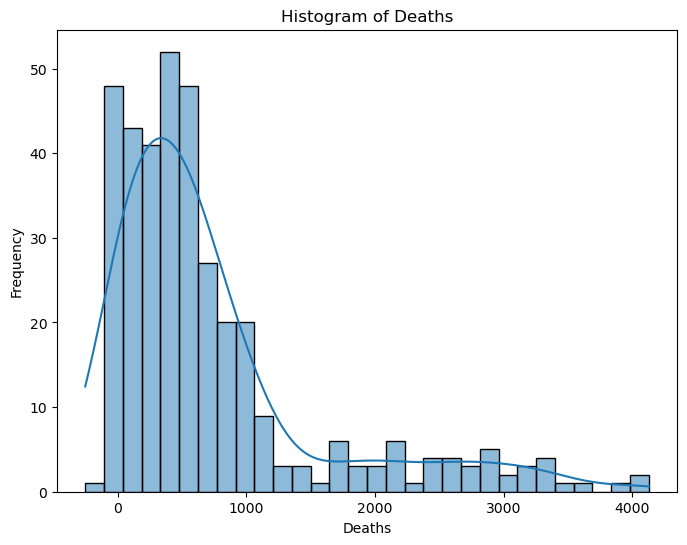

In [8]:
plt.figure(figsize=(8, 6))  # Set the figure size
sns.histplot(df['Deaths'], kde=True, bins=30)  # Plot histogram with KDE
plt.title(f'Histogram of Deaths')  # Add a title
plt.xlabel("Deaths")  # Label the x-axis
plt.ylabel('Frequency')  # Label the y-axis
plt.show()  # Display the plot

In [9]:
def check_stationary(data):
    column = data.columns[0]
    series = data[column].dropna()
    if series.empty:
        print(f"Skipping {column}: Series is empty after dropping NaN values.")
        return
    # Check if the series is constant
    if series.nunique() == 1:
        print(f"Skipping {column}: Series is constant")
        return
    # Perform ADF test
    result = adfuller(series)
    print(f"ADF Statistic for {column}: {result[0]}")
    print(f"p-value for {column}: {result[1]}")
    if result[1] > 0.05:
        print(f"{column} is non-stationary")
    else:
        print(f"{column} is stationary")
    print("\n\n")

In [10]:
def check_correlation (data):
    print("\nPlotting ACF and PACF...")
    plot_acf(data, lags=30, title="ACF of Deaths")
    plt.show()
    
    plot_pacf(data, lags=36, title="PACF of Deaths")
    plt.show()

### Testing for Stationarity

In [11]:
check_stationary(df[['Deaths']])

ADF Statistic for Deaths: -1.9546388627302662
p-value for Deaths: 0.3068094492994907
Deaths is non-stationary





### Testing Correlation


Plotting ACF and PACF...


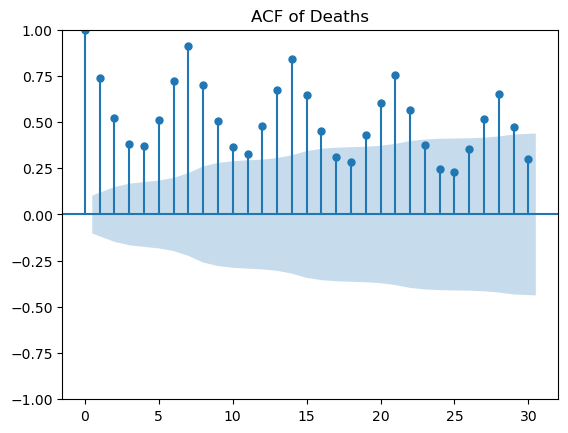

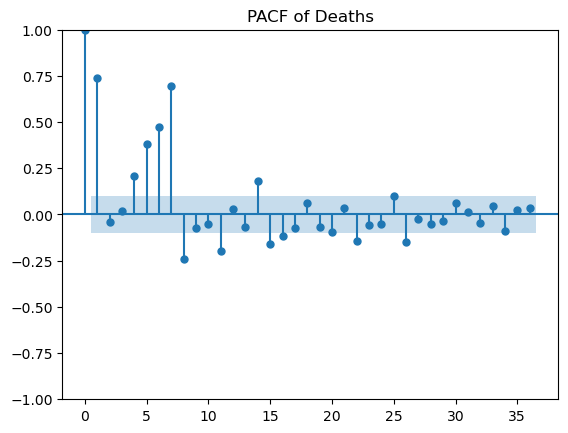

In [12]:
check_correlation(df[['Deaths']])

### Analyze trend

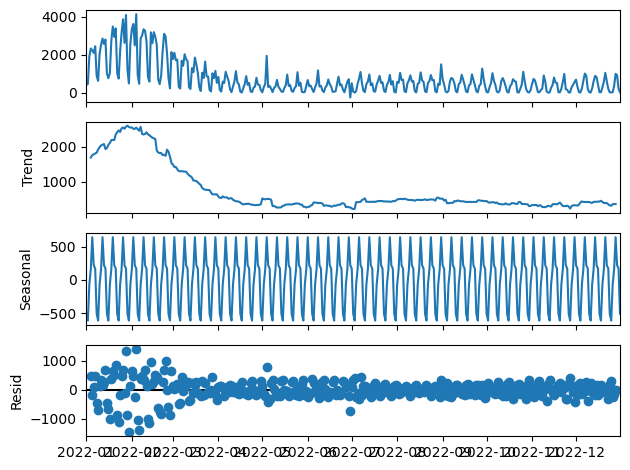

In [13]:
result = seasonal_decompose(df, model='additive', period=7)
result.plot()
plt.show()

## Preprocessing

### Scaling and Normalization

In [14]:
rScaler = RobustScaler()
df['Deaths'] = rScaler.fit_transform(df[['Deaths']])
#transformer = PowerTransformer(method='yeo-johnson')
#df['Deaths'] = transformer.fit_transform(df[['Deaths']])

ADF Statistic for Deaths: -3.3709717852802075
p-value for Deaths: 0.011989153800858354
Deaths is stationary




Plotting ACF and PACF...


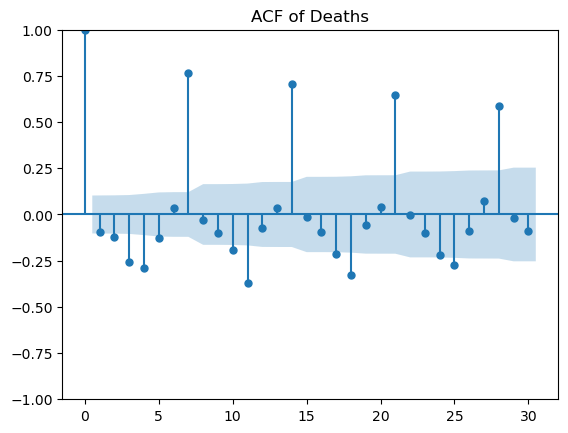

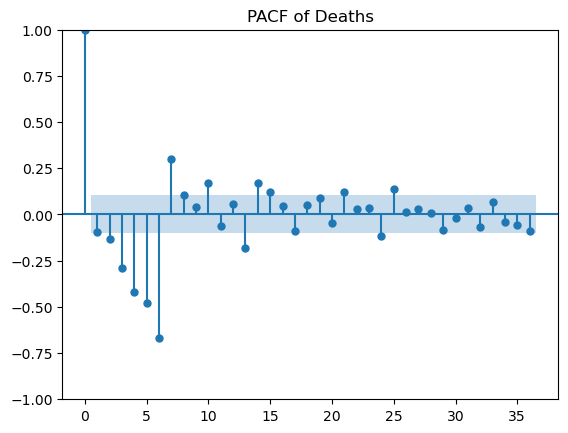

In [15]:
df = df.diff().dropna()
check_stationary(df[['Deaths']])
check_correlation(df[['Deaths']])

In [16]:
df = df.reset_index()
split_date = df['Date'].max() - pd.Timedelta(weeks=8)
train = df[df['Date'] <= split_date]
test = df[df['Date'] > split_date]

train = train.set_index("Date")
test = test.set_index("Date")

train.index = pd.DatetimeIndex(train.index).to_period('D')
test.index = pd.DatetimeIndex(test.index).to_period('D')

# ExponentialSmoothing

### Genetic Algorithm for Hyperprameter Tuning

In [17]:
def evaluate(individual):
    alpha, beta, gamma, seasonal_periods = individual  
    seasonal_periods = int(seasonal_periods)

    if seasonal_periods < 2 or gamma < 0.2 or alpha < 0.0 or beta < 0.0:
        return (float('inf'),) 

    tscv = TimeSeriesSplit(n_splits=3)  # 3 splits (adjust based on data size)
    
    sse_scores = []

    for train_index, test_index in tscv.split(train):
        train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]
        
        model = ExponentialSmoothing(
            train_fold['Deaths'],
            trend='add', 
            seasonal='add', 
            seasonal_periods=seasonal_periods
        ).fit(
            smoothing_level=alpha, 
            smoothing_trend=beta, 
            smoothing_seasonal=gamma, 
            optimized=False
        )
        
        pred = model.forecast(len(test_fold))
        sse= mean_squared_error(test_fold['Deaths'], pred)
        sse_scores.append(sse)

    return (np.mean(sse_scores),) 
def mutate_gaussian(individual,  mu=0, sigma=0.1, indpb=0.3):
    tools.mutGaussian(individual, mu=mu, sigma=sigma, indpb=indpb)
    # Ensure values remain within valid ranges
    return individual,

In [18]:
pop_size = 100
cx_pd = 0.8
mut_pb = 0.2
gen = 100
toolbox = base.Toolbox()
toolbox.register("attr_alpha", random.uniform, 0.0, 0.2) 
toolbox.register("attr_beta", random.uniform, 0.0, 1.0) 
toolbox.register("attr_gamma", random.uniform, 0.2, 1.2)  # for gamma
toolbox.register("attr_seasonal", random.randint, 2, 30)   # For seasonal periods, adjust range based on your data
creator.create("FitnessMin", base.Fitness, weights=(-1.0, ))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_alpha, toolbox.attr_beta, toolbox.attr_gamma, toolbox.attr_seasonal), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxUniform, indpb=0.5)  # Blend crossover
toolbox.register("mutate", mutate_gaussian)
toolbox.register("select", tools.selTournament, tournsize=3)  # Tournament selection

In [19]:
def run_ga():
    pop = toolbox.population(n=pop_size)  # Initial population of 100
    hof = tools.HallOfFame(1)  # Keep track of the best solution
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    result, log = eaSimpleWithElitism(pop, toolbox, cxpb=cx_pd, mutpb=mut_pb, ngen=gen, stats=stats, halloffame=hof, verbose=True)

    best_individual = hof[0]  # Return best hyperparameters

    plt.plot(log.select('min'), color='red')
    plt.plot(log.select('avg'), color='green')
    plt.xlabel('generations')
    plt.ylabel('min/avg per generation')
    plt.show()
    
    print(f"Best hyperparameters: {best_individual}")
    print(f"Best SSE: {best_individual.fitness.values}")
    return best_individual

## Training

gen	nevals	min     
0  	100   	0.404507
1  	87    	0.402334
2  	86    	0.371883
3  	75    	0.344595
4  	77    	0.340039
5  	77    	0.340039
6  	88    	0.340039
7  	93    	0.340039
8  	90    	0.339763
9  	82    	0.33957 
10 	87    	0.33957 
11 	76    	0.33957 
12 	75    	0.33957 
13 	80    	0.338733
14 	80    	0.338733
15 	85    	0.338448
16 	80    	0.337394
17 	81    	0.337394
18 	81    	0.336694
19 	78    	0.336694
20 	81    	0.336694
21 	83    	0.336694
22 	86    	0.336694
23 	86    	0.336694
24 	82    	0.336694
25 	84    	0.336694
26 	71    	0.336694
27 	82    	0.336694
28 	79    	0.336694
29 	70    	0.336694
30 	80    	0.336694
31 	88    	0.336694
32 	85    	0.336694
33 	77    	0.336694
34 	82    	0.336694
35 	84    	0.336694
36 	84    	0.336694
37 	79    	0.336694
38 	84    	0.336694
39 	84    	0.336694
40 	85    	0.336678
41 	83    	0.336678
42 	91    	0.336678
43 	82    	0.336677
44 	87    	0.336677
45 	74    	0.336677
46 	78    	0.336677
47 	73    	0.336677
48 	89    	0.336677


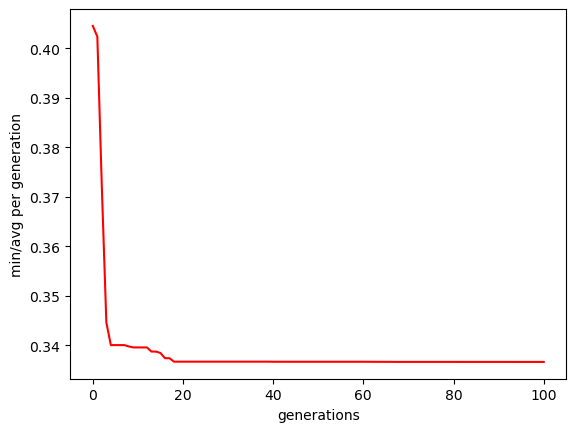

Best hyperparameters: [0.10001768576517002, 0.021468554770564544, 0.8564853902094784, 14.1398229191338]
Best SSE: (0.3366421705205336,)
                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Deaths   No. Observations:                  308
Model:             ExponentialSmoothing   SSE                            143.479
Optimized:                        False   AIC                           -199.285
Trend:                         Additive   BIC                           -132.143
Seasonal:                      Additive   AICC                          -196.358
Seasonal Periods:                    14   Date:                 Sun, 02 Feb 2025
Box-Cox:                          False   Time:                         09:30:01
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
-----------------------------------------------------

In [20]:
best_params = run_ga()  # This returns an Individual (list of alpha, beta)
alpha, beta, gamma, seasonal_periods = best_params
seasonal_periods = int(seasonal_periods)
model = ExponentialSmoothing(
        train['Deaths'],
        trend='add', 
        seasonal='add', 
        seasonal_periods=seasonal_periods
    ).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, optimized=False)

# Print results
print(model.summary())

## Prediction

In [21]:
forecast = model.forecast(steps=len(test))
deaths_pred = forecast # Predicted Deaths (scaled)
deaths_true = test["Deaths"]    
residuals = test['Deaths'] - forecast

In [22]:
mse = mean_squared_error(deaths_true, deaths_pred)
rmse = root_mean_squared_error(deaths_true, deaths_pred)
print(f"MSE for Deaths: {mse}")
print(f"Root MSE for Deaths: {rmse}")
residuals = deaths_true - deaths_pred

MSE for Deaths: 0.0589080064221479
Root MSE for Deaths: 0.24270971637358876


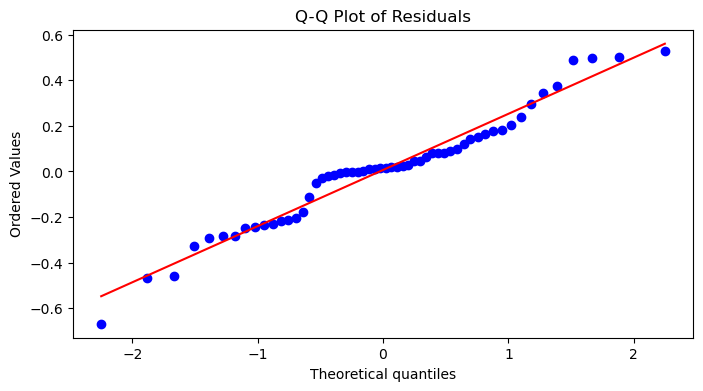

Shapiro-Wilk test p-value: 0.11748


In [23]:
plt.figure(figsize=(8, 4))
probplot(residuals, plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {shapiro_test.pvalue:.5f}")  # Should be > 0.05 for normality


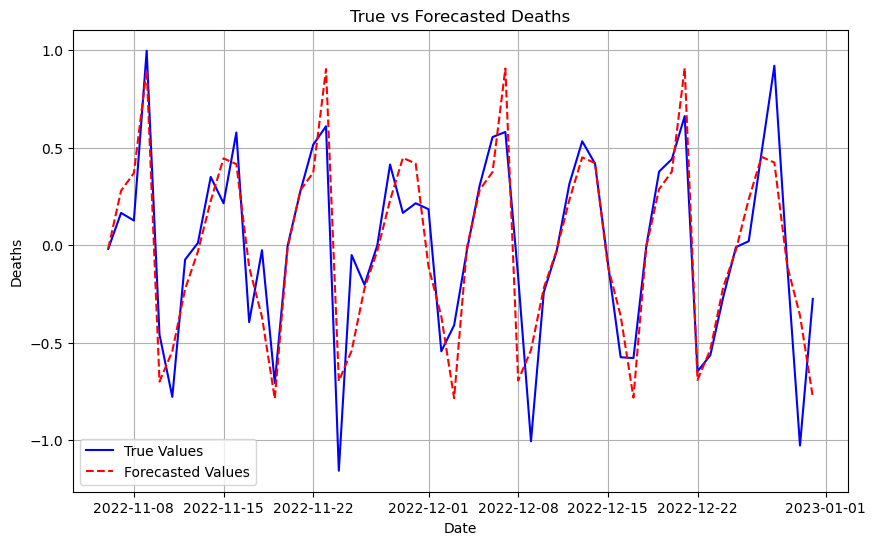

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(test.index.to_timestamp(), test['Deaths'], label='True Values', color='blue')
plt.plot(test.index.to_timestamp(), forecast, label='Forecasted Values', linestyle='--', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.title('True vs Forecasted Deaths')
plt.grid()
plt.show()

# SARIMAX

### Genetic Algorithm for Hyper Parameter tuning

In [25]:
def evaluate(individual):
    p, q, P, Q, D, d, s = individual
    s = int(s)
    if q < 0 or Q < 0 or s < 2:  # Adjust based on your seasonal_periods
        return (float('inf'),)
    tscv = TimeSeriesSplit(n_splits=3)  # 3 splits (adjust based on data size) 
    sse_scores = []
    for train_index, test_index in tscv.split(train):
        train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]
        try:
            model = SARIMAX(
                train_fold['Deaths'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_fit = model.fit(method='lbfgs', maxiter=200, disp=False)  # Faster method
            start_idx = test_fold.index[0]
            end_idx = test_fold.index[-1]
            predictions = model_fit.predict(start=start_idx, end=end_idx)
            mse = mean_squared_error(test_fold['Deaths'], predictions)
            sse_scores.append(mse)
        except Exception as e:
            return (float('inf'),)
    return (np.mean(sse_scores),)

In [26]:
toolbox = base.Toolbox()

toolbox.register("attr_p", random.randint, 3, 5)   # AR order: 0-4
toolbox.register("attr_q", random.randint, 0, 2)   # MA order: 2-4 (best=3)
toolbox.register("attr_P", random.randint, 1, 3)   # Seasonal AR: 0-2
toolbox.register("attr_Q", random.randint, 0, 1)   # Seasonal MA: 0-1 (best=1)
toolbox.register("attr_D", random.randint, 0, 1)   
toolbox.register("attr_d", random.randint, 0, 1)
toolbox.register("attr_s", lambda: random.choice([7, 12, 30]))

if hasattr(creator, "FitnessMin"):
    del creator.FitnessMin  # Remove previous FitnessMin class

if hasattr(creator, "Individual"):
    del creator.Individual  # Remove previous Individual class


creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize MSE
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_p, toolbox.attr_q, toolbox.attr_P, toolbox.attr_Q, toolbox.attr_D, toolbox.attr_d,  toolbox.attr_s), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover
toolbox.register("mutate", tools.mutUniformInt,  low=[0, 0, 0, 0, 0, 0, 7], up=[3, 2, 1, 1, 1, 1, 30], indpb=0.8)
toolbox.register("select", tools.selTournament, tournsize=2) 

In [27]:
pop_size = 100
cx_pb = 0.8  # Reduce crossover probability
mut_pb = 0.2
gens = 100

def run_ga_arima():
    pop = toolbox.population(n=pop_size)  # Initial population of 100
    hof = tools.HallOfFame(1)  # Keep track of the best solution
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    result, log = eaSimpleWithElitism(pop, toolbox, cxpb=cx_pb, mutpb=mut_pb, ngen=gens, stats=stats, halloffame=hof, verbose=True)

    best_individual = hof[0]  # Return best hyperparameters

    plt.plot(log.select('min'), color='red')
    plt.plot(log.select('avg'), color='green')
    plt.xlabel('generations')
    plt.ylabel('min/avg per generation')
    plt.show()
    
    print(f"Best hyperparameters: {best_individual}")
    print(f"Best SSE: {best_individual.fitness.values}")
    return best_individual


### Training

In [ ]:
best_param = run_ga_arima()
p, q, P, Q, D, d, s = best_param
s = int(s)
model = SARIMAX(
            train['Deaths'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
model_fit = model.fit(method='lbfgs', maxiter=200, disp=False)  # Faster method

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood o

### Prediction

In [ ]:
forecast = model_fit.predict(start=len(train), end=(len(train) + len(test) - 1))
deaths_pred = forecast # Predicted Deaths (scaled)
deaths_true = test["Deaths"]    
residuals = test['Deaths'] - forecast

In [ ]:
mse = mean_squared_error(deaths_true, deaths_pred)
rmse = root_mean_squared_error(deaths_true, deaths_pred)
print(f"MSE for Deaths: {mse}")
print(f"Root MSE for Deaths: {rmse}")

In [ ]:
plt.figure(figsize=(8, 4))
probplot(residuals, plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {shapiro_test.pvalue:.5f}")  # Should be > 0.05 for normality

In [ ]:
plt.plot(test['Deaths'], label='Training Data')
plt.plot(forecast, label='Fitted Values', linestyle='--')
plt.legend()
plt.show()